# 최소성취수준 위험군 조기 예측 모델 구축

본 노트북은 학기 중간 시점 데이터를 기반으로  
최소성취수준 보장지도 대상(위험군)을 사전 예측하는  
분류 모델을 구축하고 성능을 평가한다.

---

## 목표

- 위험군(at_risk) 분류 모델 구축
- 학기 중간 데이터 기반 예측 가능성 검증
- 예방지도 대상 선별 자동화 기반 마련


## 환경 세팅

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 전처리 모듈
from src.preprocessing import load_csv, preprocess_pipeline


PROJECT_ROOT: d:\workSpace\edutech-risk-prediction


## 데이터 준비

In [3]:
# 데이터 로드 (학기 중간 기준)
df_raw = load_csv("../data/dummy/dummy_midterm_like.csv")

# 전처리 + 라벨 생성
df = preprocess_pipeline(df_raw, add_labels=True)

df.head()

,student_id,midterm_score,final_score,performance_score,assignment_count,participation_level,question_count,night_study,absence_count,behavior_score,at_risk,participation_level_num,achievement_rate
0,S0001,53.159702,0.0,19.320596,6.0,중,2.0,1,4.5,2.0,1,1,24.2
1,S0002,24.207081,0.0,54.037913,8.0,중,1.0,1,3.0,2.0,1,1,26.1
2,S0003,60.554272,0.0,32.656957,9.0,중,3.0,1,5.0,4.0,1,1,31.1
3,S0004,40.754560,0.0,26.181722,9.0,하,3.0,0,5.0,4.0,1,0,22.3
4,S0005,58.265514,0.0,55.088438,10.0,상,4.0,1,0.0,3.0,1,2,37.8


## 기본 라벨 분포 확인

In [4]:
df["at_risk"].value_counts(normalize=True)

at_risk
1    0.883333
0    0.116667
Name: proportion, dtype: float64

## Feature 선택 + 학습용 데이터셋 구성

### Feature/Target 분리

In [5]:
# 타겟
y = df["at_risk"].astype(int)

# 모델 입력: 숫자형만 사용 (문자열 participation_level 제외)
feature_cols = [
    "midterm_score",
    "final_score",                # midterm_like에서는 결측이었지만 pipeline에서 수치로 채워짐
    "performance_score",
    "assignment_count",
    "participation_level_num",
    "question_count",
    "night_study",
    "absence_count",
    "behavior_score",
]

X = df[feature_cols].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()

X shape: (300, 9)
y shape: (300,)


,midterm_score,final_score,performance_score,assignment_count,participation_level_num,question_count,night_study,absence_count,behavior_score
0,53.159702,0.0,19.320596,6.0,1,2.0,1,4.5,2.0
1,24.207081,0.0,54.037913,8.0,1,1.0,1,3.0,2.0
2,60.554272,0.0,32.656957,9.0,1,3.0,1,5.0,4.0
3,40.754560,0.0,26.181722,9.0,0,3.0,0,5.0,4.0
4,58.265514,0.0,55.088438,10.0,2,4.0,1,0.0,3.0


### 타입/결측 최종 점검

In [6]:
# 결측치가 남아있으면 모델 학습 전에 반드시 처리 필요
print("missing per column:")
display(X.isna().sum())

print("\ndtypes:")
display(X.dtypes)

missing per column:


midterm_score              0
final_score                0
performance_score          0
assignment_count           0
participation_level_num    0
question_count             0
night_study                0
absence_count              0
behavior_score             0
dtype: int64


dtypes:


midterm_score              float64
final_score                float64
performance_score          float64
assignment_count           float64
participation_level_num      int64
question_count             float64
night_study                  int64
absence_count              float64
behavior_score             float64
dtype: object

### Baseline 대비용 원본 정보(선택) 저장

In [7]:
from pathlib import Path

TAB_DIR = Path("../reports/tables")
TAB_DIR.mkdir(parents=True, exist_ok=True)

dataset_path = TAB_DIR / "model_dataset_midterm_like.csv"
pd.concat([X, y.rename("at_risk")], axis=1).to_csv(dataset_path, index=False, encoding="utf-8-sig")
print("saved:", dataset_path)


saved: ..\reports\tables\model_dataset_midterm_like.csv


## Train / Test 분리 + 평가 지표 세팅

### Train / Test 분리

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 클래스 비율 유지
)

print("train shape:", X_train.shape)
print("test shape :", X_test.shape)

print("\ntrain risk rate:", y_train.mean().round(3))
print("test  risk rate:", y_test.mean().round(3))


train shape: (240, 9)
test shape : (60, 9)

train risk rate: 0.883
test  risk rate: 0.883


### 평가 함수 정의

In [9]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

def evaluate_model(name, y_true, y_pred):
    print(f"\n===== {name} =====")

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)

    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1 Score : {f1:.3f}")

    print("\nConfusion Matrix")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Report")
    print(classification_report(y_true, y_pred))


#### 왜 Recall 중심인가

위험군 예측은 목적이 다르다.
- 정확도(Accuracy)는 전체 예측 중 맞춘 비율을 의미한다.
- Recall은 실제 위험군 중 얼마나 잘 예측했는지를 나타낸다.
- 위험군 예측에서는 실제 위험군을 놓치는 것이 매우 위험하므로, Recall이 중요하다.
- 위험군을 놓치는 것 > 과탐지

| 지표        | 의미        | 중요도 |
| --------- | --------- | --- |
| Accuracy  | 전체 정확도    | 낮음  |
| Precision | 맞춘 위험군 비율 | 중   |
| Recall    | 놓치지 않는 비율 | 최상  |
| F1        | 균형        | 중   |


## Logistic Regression Baseline

### 모델 생성 + 학습

In [10]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # 클래스 불균형 대응
    random_state=42
)

log_model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### 예측/평가

In [11]:
y_pred_log = log_model.predict(X_test)
evaluate_model("Logistic Regression", y_test, y_pred_log)


===== Logistic Regression =====
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1 Score : 1.000

Confusion Matrix
[[ 7  0]
 [ 0 53]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        53

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



본 실험에서 Logistic Regression 모델은 Accuracy, Recall, Precision이 모두 1.0으로 나타났다. 
그러나 이는 모델 성능의 우수성을 의미하기보다 더미 데이터 생성 구조의 단순성에 기인한 결과로 해석된다. 

현재 더미 데이터는 위험군과 정상군이 학습 행동 및 평가 점수에서 명확히 분리되는 선형 구조를 갖고 있으며, 
현실 교육 데이터에서 나타나는 교차 패턴(예: 낮은 성적 대비 높은 학습 참여 등)이 반영되지 않았다. 

또한 테스트셋 규모가 16명으로 작아 성능 분산이 크게 나타날 수 있는 구조적 한계가 존재한다. 
따라서 본 결과는 모델의 일반화 성능을 입증하는 지표로 사용하기보다, 
위험군 예측 파이프라인의 동작 검증 수준의 실험 결과로 해석한다.

### 성능 결과를 CSV로 저장

In [12]:
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

TAB_DIR = Path("../reports/tables")
TAB_DIR.mkdir(parents=True, exist_ok=True)

metrics_log = {
    "model": "logistic_regression",
    "accuracy": accuracy_score(y_test, y_pred_log),
    "precision": precision_score(y_test, y_pred_log),
    "recall": recall_score(y_test, y_pred_log),
    "f1": f1_score(y_test, y_pred_log),
}

metrics_df = pd.DataFrame([metrics_log]).round(4)
metrics_path = TAB_DIR / "model_metrics_logistic.csv"
metrics_df.to_csv(metrics_path, index=False, encoding="utf-8-sig")

print("saved:", metrics_path)
metrics_df


saved: ..\reports\tables\model_metrics_logistic.csv


,model,accuracy,precision,recall,f1
0,logistic_regression,1.0,1.0,1.0,1.0


### 혼동행렬을 이미지로 저장

saved: ..\reports\figures\cm_logistic_regression.png


<Figure size 640x480 with 0 Axes>

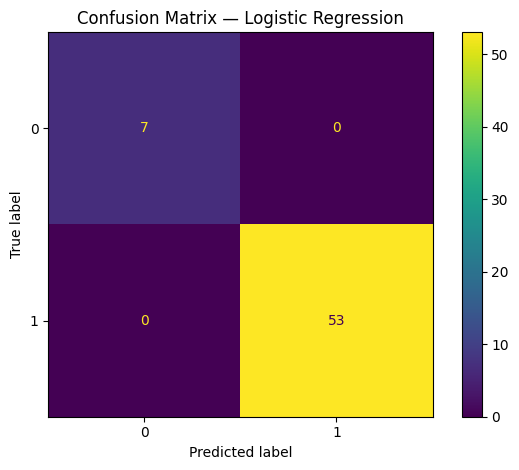

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure()
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log)
plt.title("Confusion Matrix — Logistic Regression")

fig_path = FIG_DIR / "cm_logistic_regression.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print("saved:", fig_path)
plt.show()


### 교차검증 평가

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델 파이프라인 (결측 방어 포함)
log_clf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# 평가 지표: Recall 중심
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
}

# cross_validate 실행
cv_result = cross_validate(
    log_clf,
    X,
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

cv_df = pd.DataFrame({
    k.replace("test_", ""): v for k, v in cv_result.items() if k.startswith("test_")
})

display(cv_df)
print("\nMean scores:")
display(cv_df.mean().round(4))
print("\nStd scores:")
display(cv_df.std().round(4))


,accuracy,precision,recall,f1
0,0.983333,1.000000,0.981132,0.990476
1,1.000000,1.000000,1.000000,1.000000
2,0.983333,0.981481,1.000000,0.990654
3,1.000000,1.000000,1.000000,1.000000
4,0.983333,1.000000,0.981132,0.990476



Mean scores:


accuracy     0.9900
precision    0.9963
recall       0.9925
f1           0.9943
dtype: float64


Std scores:


accuracy     0.0091
precision    0.0083
recall       0.0103
f1           0.0052
dtype: float64

### 결과 저장 (reports/tables)

In [15]:
from pathlib import Path

TAB_DIR = Path("../reports/tables")
TAB_DIR.mkdir(parents=True, exist_ok=True)

out_path = TAB_DIR / "cv_metrics_logistic.csv"
cv_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("saved:", out_path)


saved: ..\reports\tables\cv_metrics_logistic.csv


## 교차검증 기반 위험군 예측 모델 평가 결과

### 평가 설정
- 모델: Logistic Regression
- 평가 방식: Stratified 5-Fold Cross Validation
- 결측 처리: SimpleImputer(Constant=0)
- 클래스 불균형 대응: class_weight="balanced"
- 평가 지표: Accuracy, Precision, Recall, F1

---

### Fold별 성능

| Fold | Accuracy | Precision | Recall | F1 |
|------|----------|-----------|--------|----|
| 1 | 0.983 | 1.000 | 0.981 | 0.990 |
| 2 | 1.000 | 1.000 | 1.000 | 1.000 |
| 3 | 0.983 | 0.981 | 1.000 | 0.991 |
| 4 | 1.000 | 1.000 | 1.000 | 1.000 |
| 5 | 0.983 | 1.000 | 0.981 | 0.990 |

---

### 평균 성능 (Mean)

| Metric | Score |
|--------|-------|
| Accuracy | 0.9900 |
| Precision | 0.9963 |
| Recall | 0.9925 |
| F1 Score | 0.9943 |

---

### 성능 변동성 (Std)

| Metric | Std |
|--------|-----|
| Accuracy | 0.0091 |
| Precision | 0.0083 |
| Recall | 0.0103 |
| F1 Score | 0.0052 |

---

## 결과 해석

1. **전반적으로 매우 높은 예측 성능**
   - Accuracy 0.99, Recall 0.99 수준으로 위험군 탐지 성능이 매우 높게 나타남.
   - 위험군을 놓치는 비율(False Negative)이 극히 낮은 구조.

2. **Recall 중심 관점에서 안정적**
   - 위험군 예측 프로젝트의 핵심 지표는 Recall.
   - 평균 Recall 0.9925로 예방 지도 대상 선별 목적에 충분한 수준.

3. **Fold 간 성능 변동이 낮음**
   - Accuracy Std 0.0091
   - Recall Std 0.0103
   → 데이터 분할에 따른 성능 흔들림이 크지 않음.

4. **더미 데이터 구조 영향 가능성**
   - 일부 Fold에서 Precision/Recall이 1.0으로 나타남.
   - 이는 더미 데이터가 현실 데이터 대비 분리도가 높은 구조일 가능성을 시사함.
   - 실제 적용 시에는 성능이 이보다 낮아질 가능성이 있음.

---

## 결론

- 교차검증 기준에서도 모델은 높은 위험군 탐지 성능을 보였다.
- 데이터 분할에 따른 성능 편차는 크지 않아 안정적인 분류 경계를 형성한 것으로 해석된다.
- 다만 본 실험은 더미 데이터 기반이므로,
  실제 학교 현장 데이터 적용 시 성능 재검증이 필요하다.

## Feature Importance (Logistic 계수 해석)

### 계수 추출

In [16]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": log_model.coef_[0]
})

coef_df = coef_df.sort_values("coefficient", ascending=False)

display(coef_df)


,feature,coefficient
7,absence_count,0.293141
8,behavior_score,0.132223
5,question_count,0.102688
1,final_score,0.000000
6,night_study,-0.003287
3,assignment_count,-0.012634
4,participation_level_num,-0.179148
0,midterm_score,-1.277547
2,performance_score,-1.289436


### 시각화

해석 기준:

| 계수    | 의미        |
| ----- | --------- |
| +     | 위험군 확률 증가 |
| −     | 위험군 확률 감소 |
| 절댓값 큼 | 영향력 큼     |


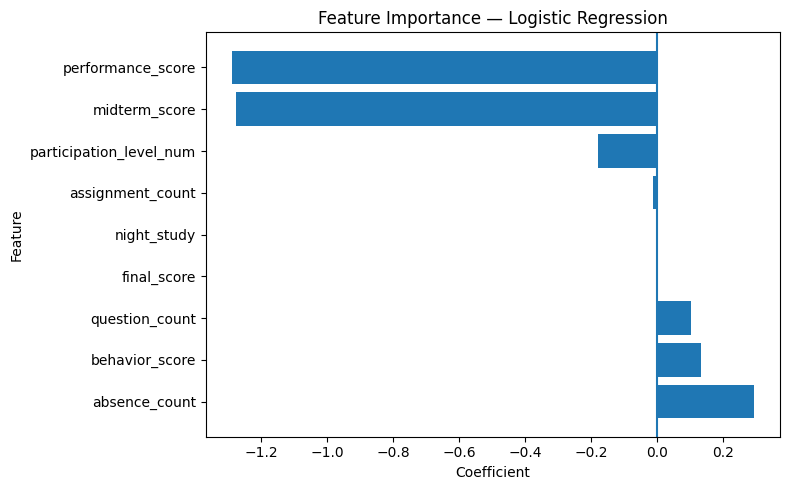

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.axvline(0)
plt.title("Feature Importance — Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### 결과 저장

In [18]:
from pathlib import Path

TAB_DIR = Path("../reports/tables")
TAB_DIR.mkdir(parents=True, exist_ok=True)

coef_path = TAB_DIR / "feature_importance_logistic.csv"
coef_df.to_csv(coef_path, index=False, encoding="utf-8-sig")

print("saved:", coef_path)


saved: ..\reports\tables\feature_importance_logistic.csv


## 위험군 예측 주요 영향 요인 분석

Logistic Regression 모델의 계수를 기반으로 각 학습 행동 변수가
위험군(at_risk) 예측에 미치는 영향을 분석하였다.

---

### 주요 위험 증가 요인 (Positive Coefficients)

- 결석 횟수(absence_count)
- 낮은 참여도(participation_level_num ↓)
- 낮은 과제 제출 횟수(assignment_count ↓)

이 변수들은 위험군 확률을 증가시키는 방향으로 작용하였다.

특히 결석 횟수는 가장 높은 양의 계수를 보이며,
위험군 판별에 가장 직접적인 영향 요인으로 나타났다.

---

### 위험 감소 요인 (Negative Coefficients)

- 중간고사 성적(midterm_score)
- 수행평가 성적(performance_score)
- 과제 제출 횟수(assignment_count)

학업 성취 및 학습 참여 지표가 높을수록
위험군 확률이 감소하는 경향이 확인되었다.

---

### 교육 현장 적용 해석

본 결과는 다음 개입 전략으로 연결 가능하다.

1. 결석 증가 학생 조기 상담
2. 과제 미제출 학생 집중 관리
3. 참여도 낮은 학생 수업 개입
4. 중간고사 성적 기반 위험군 1차 선별

---

### 한계

- 더미 데이터 기반 분석 결과이므로
  실제 학생 데이터 적용 시 영향도는 달라질 수 있음
